# Expressions

ironArray has a strong support for expression evaluation.  Things like sums, products, divisions or a pretty complete range of transcendental functions (e.g. `exp`, `sin`, `asin`, `tanh`...).  Fast evaluation of (large) arrays is one of the features that received more love during the development.  Performance comes from a balance between:

1. Use of [Intel MKL](https://software.intel.com/content/www/us/en/develop/tools/oneapi/components/onemkl.html) for accelerating transcendental functions.

2. Use of [Intel SVML](https://software.intel.com/content/www/us/en/develop/documentation/cpp-compiler-developer-guide-and-reference/top/compiler-reference/intrinsics/intrinsics-for-short-vector-math-library-operations/overview-intrinsics-for-short-vector-math-library-svml-functions.html) for computing vector math functions.

3. Use of multi-threading capabilities.

4. Leveraging the 2-level partitioning in ironArray arrays so that most of the computation intensive happens inside private caches (L1, L2), which benefits multi-threading performance.

You can access to the powerful evaluation capabilities in ironArray in different ways, which we are going to succinctly expose in this tutorial.  In order to do that, we are going to make use of the dataset that we created in our reductions tutorial.  Let's go:


In [1]:
import numpy as np
import iarray as ia
from ipython_memwatcher import MemWatcher

mw = MemWatcher()
mw.start_watching_memory()
meas = {}

In [1] used 0.008 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 101.141 MiB


In [2]:
ia_precip = ia.load("precip-3m.iarr")
ia_precip

<IArray (3, 720, 721, 1440) np.float32>

In [2] used 5.285 MiB RAM in 0.008s, peaked 0.000 MiB above current, total RAM usage 104.152 MiB


Now, in order to evaluate some expressions on this, let's put the data for each month on a different array:

In [13]:
precip1 = ia_precip[0].copy()
precip2 = ia_precip[1].copy()
precip3 = ia_precip[2].copy()

In [13] used 1716.773 MiB RAM in 21.514s, peaked 0.000 MiB above current, total RAM usage 1881.770 MiB


Note how, even if the data for all the three months takes almost 9 GB uncompressed, ironArray has used just a bit more than 1.7 GB for holding them in RAM.  This is compression at work.

With that, let's compute something easy, like a new array with the mean of these.  For that, we are going to use the internal evaluation engine:

In [4]:
precip_expr = ia.expr_from_string("(p1 + p2 + p3) / 3", {'p1': precip1, 'p2': precip2, 'p3': precip3})

In [4] used 10.941 MiB RAM in 0.021s, peaked 0.000 MiB above current, total RAM usage 1712.523 MiB


Ok, that was fast, but we did not quite evaluate anything yet.  In order to do the actual evaluation, we have to call `.eval()` on the expression:

In [5]:
precip_mean = precip_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

In [5] used 1251.723 MiB RAM in 1.600s, peaked 0.000 MiB above current, total RAM usage 2964.246 MiB


In [6]:
meas["ia_mean"] = mw.measurements

In [6] used 0.000 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 2964.246 MiB


Cool, so we have our first evaluation done.  But let's see how it performs against NumPy, and especially, whether the outcome is correct:

In [7]:
np_precip1 = precip1.data
np_precip2 = precip2.data
np_precip3 = precip3.data

In [7] used 8563.930 MiB RAM in 6.629s, peaked 0.000 MiB above current, total RAM usage 11528.176 MiB


Here we see how the data takes about 9 GB of RAM.  Now, let's do the actual mean:

In [8]:
np_precip_mean = (np_precip1 + np_precip2 + np_precip3) / 3

In [8] used 2852.645 MiB RAM in 1.801s, peaked 0.000 MiB above current, total RAM usage 14380.820 MiB


In [9]:
meas["np_mean"] = mw.measurements

In [9] used 0.051 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 14380.871 MiB


So, ironArray times are quite competitive with NumPy.  How about the correctness of the outcome?.  Let's see:

In [10]:
np.testing.assert_almost_equal(np_precip_mean, precip_mean.data)

In [10] used -8762.574 MiB RAM in 19.118s, peaked 14212.305 MiB above current, total RAM usage 5618.297 MiB


Cool, results are the same. That means that ironArray can run generally faster than NumPy, even if the former uses data in compressed form by default.

Now, let's use expressions with some transcendental functions.  This does not make sense for this case (precipitation data), but we are doing this just as an indication of the efficiency of ironArray:

In [11]:
result = ia.expr_from_string("(tan(p1) * (sin(p1) * sin(p2) + cos(p2)) + sqrt(p3) * 2)",
                             {'p1': precip1, 'p2': precip2, 'p3': precip3}
                             ).eval()
result

<IArray (720, 721, 1440) np.float32>

In [11] used 1904.930 MiB RAM in 2.494s, peaked 0.000 MiB above current, total RAM usage 7523.227 MiB


In [12]:
meas["ia_trans"] = mw.measurements

In [12] used 0.117 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 7523.344 MiB


In this case we see that the overhead of using transcendental functions is pretty low compared with plain arithmetic operations (sum, rest, mult, division...). Let's compare this against NumPy:

In [13]:
p1_ = np_precip1
p2_ = np_precip2
p3_ = np_precip3
np_result = (np.tan(p1_) * (np.sin(p1_) * np.sin(p2_) + np.cos(p2_)) + np.sqrt(p3_) * 2)

In [13] used 9303.387 MiB RAM in 20.579s, peaked 3558.570 MiB above current, total RAM usage 16826.730 MiB


In [14]:
meas["np_trans"] = mw.measurements

In [14] used 0.047 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 16826.777 MiB


Ok, this is really slow, but this is kind of expected, as ironArray comes with support for evaluating transcendental functions via MKL, while NumPy does not.

But do not forget to check for correctness:

In [15]:
np.testing.assert_almost_equal(np_result, result.data)

In [15] used -5482.352 MiB RAM in 20.135s, peaked 12635.691 MiB above current, total RAM usage 11344.426 MiB


Yes, not a noticeable difference, as expected.

## Lazy expressions

So far we have been using strings as the way to build expressions.  However, there is a handier (and perhaps more elegant) way to build expressions via the so-called lazy expressions.  With lazy expressions you just express your computations in terms of `IArray` objects.

For example, the mean of the precipitation would be expressed as:

In [16]:
precip_expr = (precip1 + precip2 + precip3) / 3

In [16] used 0.520 MiB RAM in 0.012s, peaked 0.000 MiB above current, total RAM usage 11344.945 MiB


In [17]:
precip_mean = precip_expr.eval()
precip_mean

<IArray (720, 721, 1440) np.float32>

In [17] used 1288.156 MiB RAM in 1.697s, peaked 0.000 MiB above current, total RAM usage 12633.102 MiB


In [18]:
meas["ia_mean_lazy"] = mw.measurements

In [18] used 0.023 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 12633.125 MiB


Lazy expressions are similar to how you use NumPy to evaluate expressions with some differences:

1. You need to be explicit when you want to `.eval()`-uate the expressions.

2. There are no big temporaries involved.  The expression is compiled on the flight and large temporaries are avoided.  This means not only that we require less memory, but more importantly, that expressions evaluate faster (memory access is always expensive).

For evaluating expressions with transcendental functions you need to use ironArray methods:

In [19]:
lazy_expr = ia.tan(precip1) * (ia.sin(precip1) * ia.sin(precip2) + ia.cos(precip2)) + ia.sqrt(precip3) * 2
# Yoy can also use the next idiom, which is not as close to NumPy, but a hair more concise
#lazy_expr = precip1.tan() * (precip1.sin() * precip2.sin() + precip2.cos()) + precip3.sqrt() * 2

In [19] used 0.082 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 12633.207 MiB


In [20]:
lazy_result = lazy_expr.eval()
lazy_result


<IArray (720, 721, 1440) np.float32>

In [20] used 1056.586 MiB RAM in 2.321s, peaked 0.000 MiB above current, total RAM usage 13689.793 MiB


In [21]:
meas["ia_trans_lazy"] = mw.measurements

In [21] used 0.051 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 13689.844 MiB


Note how execution times and memory usage are very similar to the string expressions evaluator.

As you can see, lazy expressions allow for a more Pythonic way to integrate ironArray operands in expressions, just like NumPy (only more memory efficient and faster).  In general, you can use the method you like the most, although evaluation of string expressions tends to be a hair faster, especially when using small arrays.

As always, let's check that the result is correct:

In [22]:
np.testing.assert_almost_equal(np_result, lazy_result.data)

In [22] used -4832.316 MiB RAM in 22.544s, peaked 13987.645 MiB above current, total RAM usage 8857.527 MiB


## Resource consumption

As a summary, let's do a plot on the speed for the different kind of computations:

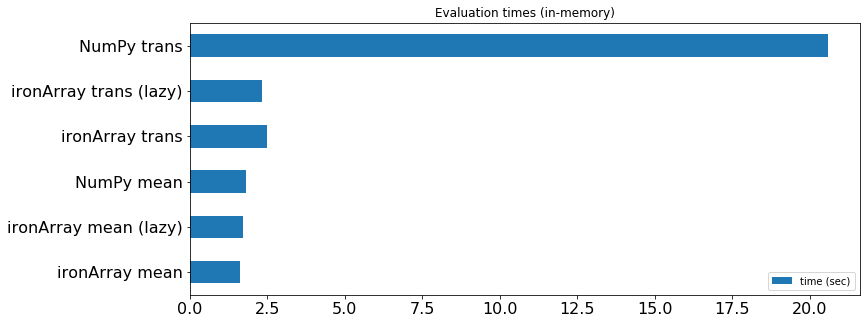

In [23] used 74.641 MiB RAM in 0.701s, peaked 0.000 MiB above current, total RAM usage 8932.168 MiB


In [23]:
%matplotlib inline
import pandas as pd

labels = ["ironArray mean",
          "ironArray mean (lazy)",
          "NumPy mean",
          "ironArray trans",
          "ironArray trans (lazy)",
          "NumPy trans"]
df = pd.DataFrame({'time (sec)': [
    meas["ia_mean"].time_delta,
    meas["ia_mean_lazy"].time_delta,
    meas["np_mean"].time_delta,
    meas["ia_trans"].time_delta,
    meas["ia_trans_lazy"].time_delta,
    meas["np_trans"].time_delta]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Evaluation times (in-memory)")

and the memory used for every kind of computations:

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...
In [47] used 0.039 MiB RAM in 21.957s, peaked 0.000 MiB above current, total RAM usage 4188.570 MiB
In [47] used 0.039 MiB RAM in 22.062s, peaked 0.000 MiB above current, total RAM usage 4188.570 MiB


TypeError: format() argument after * must be an iterable, not NoneType

/Users/faltet/miniconda3/envs/iarray/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2838: UserWarning: Unknown failure executing module: <mprof>
  warn('Unknown failure executing module: <%s>' % mod_name)


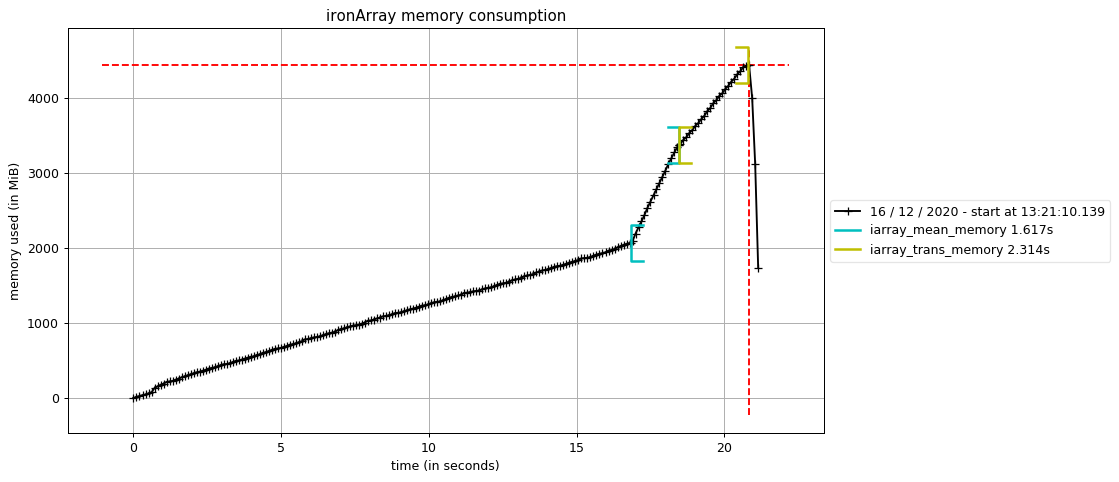

In [47]:
%rm iarray_mean_memory.dat
%run -m mprof run -o iarray_mean_memory.dat iarray_mean_memory.py
%run -m mprof plot iarray_mean_memory.dat -t "ironArray memory consumption"

The first part of the plot is the loading process of the 3 months of precipitation arrays from disk.  This process stops when 2 GB is reached, meaning that the data takes that in memory (remember that we are dealing with compressed data).  The part between blue brackets corresponds to the actual mean computation (1.5 GB was needed to host the mean array).  Finally, the yellow brackets show the computation of the transcendental expression (around 1 GB more).  In the end, ironArray has needed 4.5 GB so as to evaluate the two expresions.

Let's see what is the memory consumption for NumPy:

In [3]:
%rm numpy_mean_memory.dat
%run -m mprof run -o numpy_mean_memory.dat numpy_mean_memory.py
%run -m mprof plot numpy_mean_memory.dat -t "NumPy memory consumption"

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...
In [3] used -33.773 MiB RAM in 35.481s, peaked 33.922 MiB above current, total RAM usage 70.379 MiB


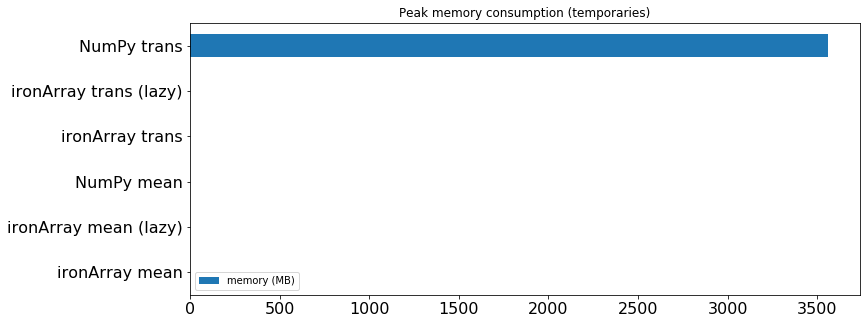

In [27] used 3.383 MiB RAM in 0.131s, peaked 0.000 MiB above current, total RAM usage 3565.766 MiB


In [27]:
labels = [
    "ironArray mean",
    "ironArray mean (lazy)",
    "NumPy mean",
    "ironArray trans",
    "ironArray trans (lazy)",
    "NumPy trans"]
df = pd.DataFrame({'memory (MB)': [
    meas["ia_mean"].memory_peak,
    meas["ia_mean_lazy"].memory_peak,
    meas["np_mean"].memory_peak,
    meas["ia_trans"].memory_peak,
    meas["ia_trans_lazy"].memory_peak,
    meas["np_trans"].memory_peak]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Peak memory consumption (temporaries)")

In this case, the first part of the plot stops around 8.5 GB (the size of the uncompressed dataset).  The section between blue brackets is where the mean is computed.  In this case, NumPy is well optimized, as it does not seem to use big temporaries.  However, the section for the transcendental evaluation (yellow brackets) shows a more complex pattern, with 3 peaks before reaching the end of the computation.  Those 3 peaks clearly correspond to the 3 big temporaries that were needed during the evaluation.  In the end, NumPy has needed 17 GB so as to evaluate the two expressions.

In general, this means that ironArray can perform operations requiring less memory than using non-compressed arrays, while using a similar time (or much less, like e.g. expressions requiring large temporaries or intermediate function evaluation).

Another advantage of ironArray is that it can perform evaluations on data that is on disk (aka out-of-core), transparently to the user.  And due to its memory efficiency (no big temporaries), the amount of memory needed would be really low.  Keep reading.

## Out-of-Core Expressions

So far we have been evaluating expressions on top of arrays that are in-memory.  One of the nice features of ironArray is that it can seamslessly handle arrays that are on-disk too; this capability is also known as out-of-core operation.

So as to show this, we are going to use our original on-disk array and will create an on-disk outcome where we will put the result of our operations.  Let's start:

In [11]:
precip1 = ia_precip[0]
precip2 = ia_precip[1]
precip3 = ia_precip[2]

In [11] used 0.070 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 164.926 MiB


In this case, we are just getting views of the larger array that is on-disk.  Remember that views do not create new containers, so this is why the above operation is fast.  Now, let's build the expression for the mean values:

In [29]:
precip_mean = (precip1 + precip2 + precip3) / 3

In [29] used 0.004 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 3565.797 MiB


and now let's evaluate and make sure that the result is created on-disk:

In [30]:
with ia.config(storage=ia.Storage(filename="mean-3m.iarr")) as cfg:
    precip_mean_disk = precip_mean.eval(cfg=cfg)
precip_mean

In [30] used 75.445 MiB RAM in 23.404s, peaked 0.000 MiB above current, total RAM usage 3641.242 MiB


In [31]:
meas["ia_mean_disk"] = mw.measurements

In [31] used -0.078 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 3641.164 MiB


We see that evaluation from disk takes quite more than operating in memory, but this is kind of expected.  What we are more interested here is the amount of RAM needed to perform the evaluation has been on the order of 100 MB, whereas the output array is quite larger than this:

In [32]:
%ls -lh mean-3m.iarr

-rw-r--r--  1 faltet  staff   1.2G Dec 16 13:04 mean-3m.iarr
In [32] used 0.004 MiB RAM in 0.515s, peaked 0.000 MiB above current, total RAM usage 3641.168 MiB


So, with a result size of more than 1 GB, it is more than 10x than the memory used.  In addition, the 100 MB in memory is probably being taken by temporaries that Python takes some time to release back, so in the long run this figure should be considered more a temporary peak that will be eventually reclaimed by the interpreter for other uses.  But still, it is important to realize that this memory is needed.

For the sake of comparison, let's see how similar array libraries perform at this.  Zarr is the most obvious container because it supports the same Blosc compressor, so this will allow for a apple to apple comparison.  Let's create a Zarr container out of our current one:

In [33]:
import zarr
from functools import reduce
ia_defs = ia.Config()

In [33] used 0.547 MiB RAM in 0.048s, peaked 0.000 MiB above current, total RAM usage 3641.715 MiB


In [34]:
blocksize = reduce(lambda x, y: x * y, ia_precip.blockshape) * np.dtype(np.float32).itemsize
zarr_precip = zarr.open(
    "precip-3m.zarr", "w", shape=ia_precip.shape, chunks=ia_precip.chunkshape, dtype=ia_precip.dtype,
    compressor=zarr.Blosc(clevel=ia_defs.clevel, cname="lz4", blocksize=blocksize),
)

In [34] used 0.047 MiB RAM in 0.027s, peaked 0.000 MiB above current, total RAM usage 3641.762 MiB


and do the copy:

In [35]:
ia_precip.copyto(zarr_precip)

In [35] used 239.602 MiB RAM in 179.801s, peaked 1054.930 MiB above current, total RAM usage 3881.363 MiB


and now do the mean by using Dask:

In [36]:
import dask
import dask.array as da

In [36] used 3.438 MiB RAM in 0.227s, peaked 0.000 MiB above current, total RAM usage 3884.801 MiB


In [37]:
precip_mean_disk = ia.load("mean-3m.iarr")
blocksize = reduce(lambda x, y: x * y, precip_mean_disk.blockshape) * np.dtype(np.float32).itemsize
shape = precip_mean_disk.shape
chunks = precip_mean_disk.chunkshape
dtype = np.float32
clevel = ia_defs.clevel

In [37] used 1.082 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 3885.883 MiB


In [38]:
with dask.config.set(scheduler="threads"):
    precip = zarr.open("precip-3m.zarr")
    d = da.from_zarr(precip)
    precip1 = d[0]
    precip2 = d[1]
    precip3 = d[2]
    res = (precip1 + precip2 + precip3) / 3
    zarr_precip_mean_disk = zarr.open(
        "mean-3m.zarr",
        "w",
        shape=shape,
        chunks=chunks,
        dtype=dtype,
        compressor=zarr.Blosc(clevel=clevel, cname="lz4", blocksize=blocksize),
    )
    da.to_zarr(res, zarr_precip_mean_disk)

In [38] used 601.082 MiB RAM in 61.835s, peaked 11936.820 MiB above current, total RAM usage 4486.965 MiB


In [39]:
meas["dask_mean_disk"] = mw.measurements

In [39] used 0.020 MiB RAM in 0.000s, peaked 0.000 MiB above current, total RAM usage 4486.984 MiB


In this case we see that Dask+Zarr took about 3x more time than ironArray in performing the operations.  But perhaps more importantly, Dask+Zarr took a considerable about of peak RAM to complete the operation (more than 10 GB), which is much more than ironArray (around 100 MB).

Here it is a comparison of the times on a plot:

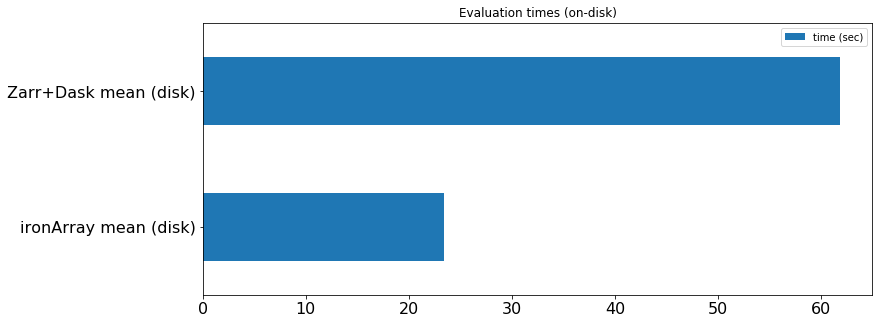

In [40] used 0.105 MiB RAM in 0.106s, peaked 0.000 MiB above current, total RAM usage 4487.090 MiB


In [40]:
%matplotlib inline
import pandas as pd

labels = ["ironArray mean (disk)", "Zarr+Dask mean (disk)"]
df = pd.DataFrame({'time (sec)': [
    meas["ia_mean_disk"].time_delta, meas["dask_mean_disk"].time_delta]},
    index=labels)
df.plot(kind='barh', figsize=(12,5), fontsize=16, title="Evaluation times (on-disk)")

And here the memory consumption for ironArray:

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...
In [8] used 5.488 MiB RAM in 37.010s, peaked 0.000 MiB above current, total RAM usage 134.680 MiB


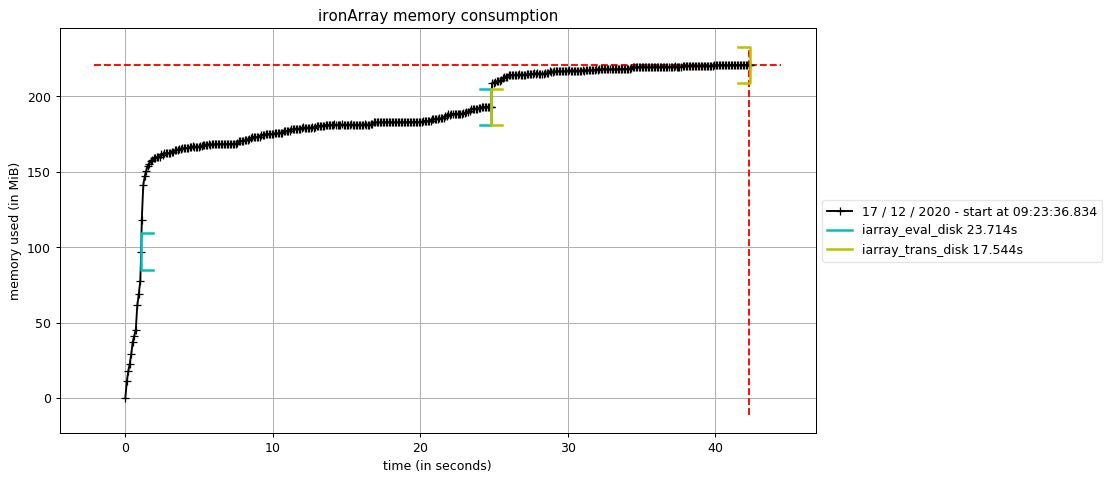

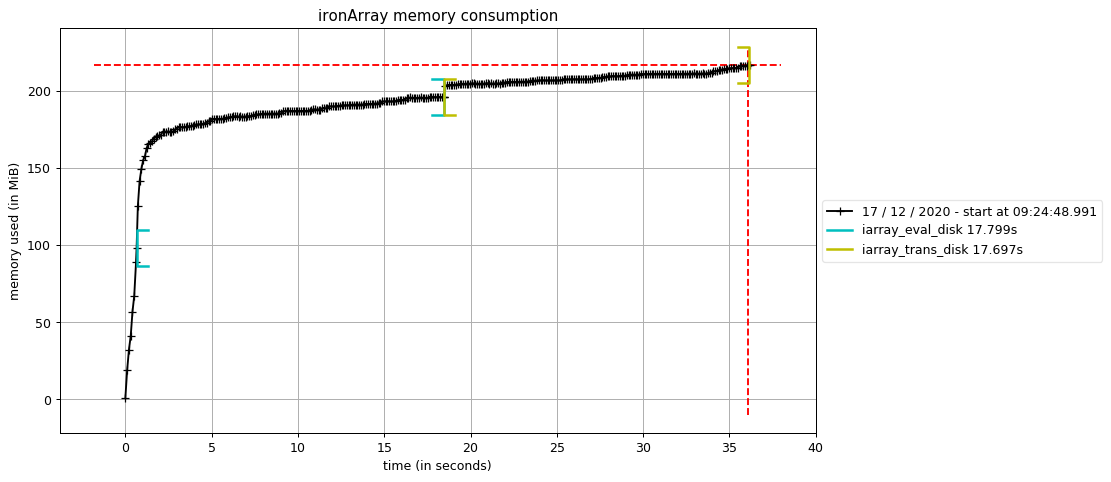

In [8]:
%rm iarray_mean_disk.dat
%run -m mprof run -o iarray_mean_disk.dat iarray_mean_disk.py
%run -m mprof plot iarray_mean_disk.dat -t "ironArray memory consumption"

In this case we see that the first operation consumes a good amount of memory (100 MB), while the second is much more contained about it (~30 MB).

The same for dask:

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...
In [9] used 5.762 MiB RAM in 135.864s, peaked 0.000 MiB above current, total RAM usage 140.441 MiB


TypeError: format() argument after * must be an iterable, not NoneType

/Users/faltet/miniconda3/envs/iarray/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2838: UserWarning: Unknown failure executing module: <mprof>
  warn('Unknown failure executing module: <%s>' % mod_name)


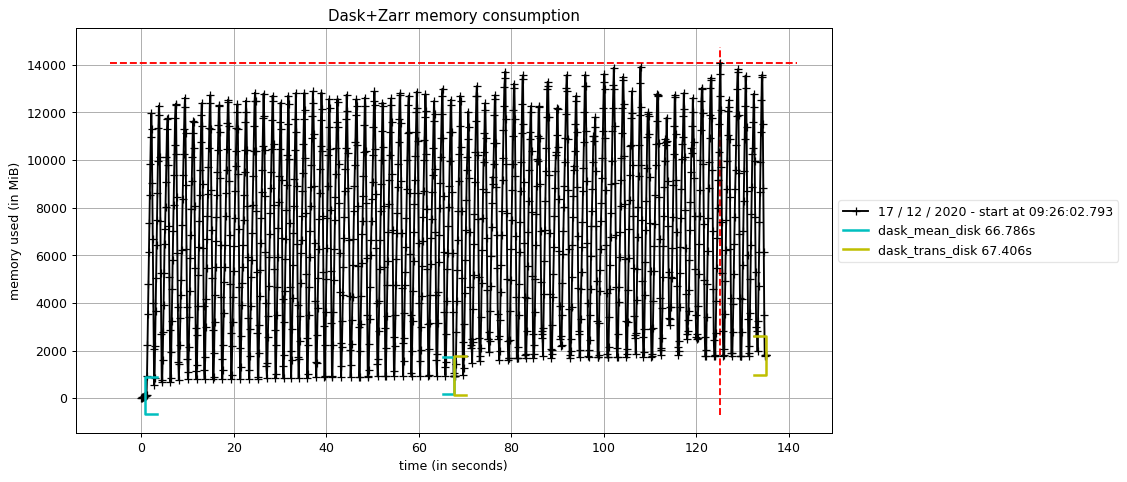

In [9]:
%rm dask_mean_disk.dat
%run -m mprof run -o dask_mean_disk.dat dask_mean_disk.py
%run -m mprof plot dask_mean_disk.dat -t "Dask+Zarr memory consumption"

One can see how ironArray is very efficient in terms of memory usage (220 MB vs 14 GB that uses Dask).  That means that ironArray can complete very large on-disk computations without a need to have large amounts of RAM in the host.

This is a general feature of ironArray: perform evaluations fast while keeping memory usage low.  This allows to compute operations on arbitrarily large arrays (as long as disk storage allows) without worrying about RAM capacities.

## Optimization Tips

Even if ironArray has been very competitive in terms of speed and memory consumption, so far the computations have been done using just the default values.  Let's see how we can accelerate things here.

One aspect that we have seen the sections above is that computation from disk is much slower than from memory.  In this section we want to explore how we can accelerate the on-disk performance as much as possible.  We know that larger chunks tend to accelerate I/O (because sequential access is faster than random access).  Here are the current chunk and block shapes:

In [2]:
ia_precip = ia.load("precip-3m.iarr")
ia_precip.info

type                : IArray
shape               : (3, 720, 721, 1440)
chunkshape          : (1, 64, 64, 128)
blockshape          : (1, 16, 16, 64)
In [2] used 4.191 MiB RAM in 0.004s, peaked 0.000 MiB above current, total RAM usage 101.645 MiB


But if you remember from the tutorial on reductions, we already reached to kind of 'optimal' chunks for reductions:

In [3]:
ia_precip_opt = ia.load("precip-3m-optimal.iarr")
ia_precip_opt.info

type                : IArray
shape               : (3, 720, 721, 1440)
chunkshape          : (1, 360, 128, 1440)
blockshape          : (1, 8, 8, 720)
In [3] used 4.047 MiB RAM in 0.006s, peaked 0.000 MiB above current, total RAM usage 109.223 MiB


In this case, the chunks are considerably larger.  Let's see how this effects to our computations:

In [6]:
precip1 = ia_precip_opt[0]
precip2 = ia_precip_opt[1]
precip3 = ia_precip_opt[2]

In [6] used 0.039 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 139.602 MiB


In [8]:
precip_mean = (precip1 + precip2 + precip3) / 3
with ia.config(storage=ia.Storage(filename="mean-3m-optimal.iarr")) as cfg:
    precip_mean_disk = precip_mean.eval(cfg=cfg)
precip_mean

In [8] used 784.266 MiB RAM in 42.282s, peaked 0.000 MiB above current, total RAM usage 1952.207 MiB


Ok, so no luck here.  The reason maybe is that too large chunks can lead to L3 cache overflows when doing the operations.  Perhaps it is better to be a bit more conservative and try with just a 4x larger chunk:

In [8]:
with ia.config(chunkshape=(1, 128, 128, 128), blockshape=(1, 16, 16, 64), filename="precip-3m-test.iarr") as cfg:
    new_precip = ia_precip.copy(cfg=cfg)

In [8] used 24.109 MiB RAM in 19.390s, peaked 0.000 MiB above current, total RAM usage 681.012 MiB


Redo the in-memory computation:

In [9]:
precip1 = new_precip[0].copy()
precip2 = new_precip[1].copy()
precip3 = new_precip[2].copy()
precip_mean = (precip1 + precip2 + precip3) / 3

In [9] used 1513.531 MiB RAM in 13.690s, peaked 0.000 MiB above current, total RAM usage 2194.543 MiB


In [10]:
precip_mean = precip_mean.eval()

In [10] used 1274.191 MiB RAM in 1.839s, peaked 0.000 MiB above current, total RAM usage 3468.734 MiB


And now, redo the on-disk evaluation:

In [11]:
precip1 = new_precip[0]
precip2 = new_precip[1]
precip3 = new_precip[2]
precip_mean = (precip1 + precip2 + precip3) / 3
with ia.config(storage=ia.Storage(filename="mean-3m-optimal.iarr")) as cfg:
    precip_mean_disk = precip_mean.eval(cfg=cfg)

In [11] used -1696.281 MiB RAM in 17.191s, peaked 1696.281 MiB above current, total RAM usage 1772.453 MiB


So, we see that the times do not change too much for either in-memory or on-disk evaluations.  Behind the scenes, the writer of this tutorial tried different configurations, but timings did not improve significantly.  That means that the defaults that are set automatically are generally good enough for most of the expressions out there.

Before closing, let us remember that the mean that we are evaluating is just a reduction, so maybe we can have a better luck with using the reduction machinery.  Let's do that with the optimal chunk and block shapes that we have determined before:

In [11]:
precip_opt = ia.load("precip-3m-optimal.iarr")
new_precip_opt = precip_opt.copy()

In [11] used 1852.152 MiB RAM in 79.433s, peaked 0.004 MiB above current, total RAM usage 3103.699 MiB


First, for in-memory:

In [12]:
reduc1 = ia.mean(new_precip_opt, axis=(3, 2, 0))

--> Config(codec=<Codecs.LZ4: 1>, clevel=5, filters=[<Filters.SHUFFLE: 1>], fp_mantissa_bits=0, use_dict=False, nthreads=12, eval_method=<Eval.AUTO: 1>, seed=1, random_gen=<RandomGen.MERSENNE_TWISTER: 0>, storage=Storage(chunkshape=(1, 64, 64, 128), blockshape=(1, 16, 16, 64), filename=None, enforce_frame=False, plainbuffer=False), chunkshape=None, blockshape=None, filename=None, enforce_frame=False, plainbuffer=False)
In [12] used 12.980 MiB RAM in 1.261s, peaked 0.000 MiB above current, total RAM usage 3116.680 MiB


Let's see how much memory this is using:

rm: iarray_reduc_memory.dat: No such file or directory
mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...
In [5] used 12.262 MiB RAM in 82.140s, peaked 0.000 MiB above current, total RAM usage 984.852 MiB


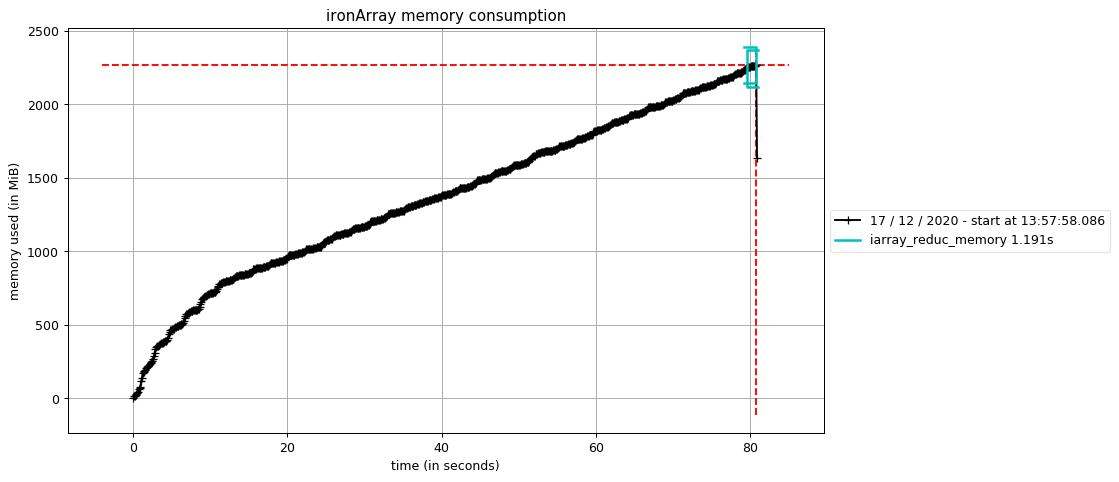

In [5]:
%rm iarray_reduc_memory.dat
%run -m mprof run -o iarray_reduc_memory.dat iarray_reduc_memory.py
%run -m mprof plot iarray_reduc_memory.dat -t "ironArray memory consumption"

TODO: spot a way to measure just the memory samples in a cell

Then, for on-disk:

In [13]:
# This does not create the output yet (https://github.com/inaos/iron-array/issues/380)
with ia.config(storage=ia.Storage(filename="reduc-3m-optimal.iarr")) as cfg:
    reduc2 = ia.mean(precip_opt, axis=(3, 2, 0), cfg=cfg)

--> Config(codec=<Codecs.LZ4: 1>, clevel=5, filters=[<Filters.SHUFFLE: 1>], fp_mantissa_bits=0, use_dict=False, nthreads=12, eval_method=<Eval.AUTO: 1>, seed=1, random_gen=<RandomGen.MERSENNE_TWISTER: 0>, storage=Storage(chunkshape=(1, 64, 64, 128), blockshape=(1, 16, 16, 64), filename='reduc-3m-optimal.iarr', enforce_frame=True, plainbuffer=False), chunkshape=None, blockshape=None, filename='reduc-3m-optimal.iarr', enforce_frame=True, plainbuffer=False)
In [13] used 60.344 MiB RAM in 5.539s, peaked 0.000 MiB above current, total RAM usage 3177.023 MiB


In [ ]:
mw.stop_watching_memory()